In [2]:
import numpy as np
import torch
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import librosa
import random
from scipy.optimize import minimize

# for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [5]:
import cfg

# Test room parameters
room_dim= [10.0, 10.0, 5.0]
t60 = 1.0 #seconds
snr = 0 # dB

# Microphone locations
mic_locs = np.array([[1.0,1.0,1.0], [9.0,9.0,1.0]]).T

# Sound source position at the same hight
source_loc = np.array([5.0,5.0,2.5])

# Create the virtual room
e_absorption, max_order = pra.inverse_sabine(t60, room_dim)

room = pra.ShoeBox(room_dim, fs=cfg.fs, materials=pra.Material(
    e_absorption), max_order=max_order)

c = room.c #speed of sound

room.add_source(source_loc, signal=signal)
room.add_microphone(mic_locs)

fig, ax = room.plot()
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, room_dim[2]])
plt.title('Virtual room')
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(mic_locs[0], mic_locs[1], c='b', label='microphones')
ax.scatter(source_loc[0], source_loc[1], c='r', label='sound source')
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
plt.title('From above')
plt.legend()
plt.show()

NameError: name 'signal' is not defined

In [ ]:
room.plot_rir()
h = room.rir

In [ ]:
room.simulate(snr=snr)

m = room.mic_array.signals
plt.plot(m[0])

# Pick a 2048 samples long snippet
sig_len = fs*5
start_idx = 20000
end_idx = start_idx + sig_len

x = torch.Tensor(m[:, start_idx:end_idx])
print(x.shape)
plt.plot(range(start_idx,end_idx), x[0].squeeze())
plt.title("Signal received at mic 0")

In [ ]:
print(x.shape)
Audio(x[0], rate = fs)

In [ ]:
import cfg_dereverb as cfgs
import numpy as np
import filterbank
import lib
import estimator

p = np.hanning(512)

''' Signal processing
% The algorithm itself is real-time capable, i.e., no processing of the entire
% utterance is necessary. Here however, for efficiency of the MATLAB implementation,
% the entire signal is processed at once.
'''
x = signal
# analysis filterbank
X=filterbank.DFTAnaRealEntireSignal(x,cfgs.K,cfgs.N,p)
print(X.shape)
# estimate PSD and coherence
Pxx = lib.estimate_psd(X,cfgs.nr["lambda"])
# Cxx = lib.estimate_cpsd(X[0,:,:],X[1,:,:],cfgs.nr["lambda"])/np.sqrt(Pxx[0,:,:]*Pxx[1,:,:])
Cxx = lib.estimate_temporal_coherence(X, cfgs.nr["lambda"])  # 새로운 coherence 추정 함수 필요

frequency = np.linspace(0,cfgs.fs/2,int(cfgs.K/2+1)) # frequency axis

# define coherence models
Css = np.exp(1j * 2 * np.pi * frequency * cfgs.TDOA)              # target signal coherence; not required for estimate_cdr_nodoa
Cnn = np.sinc(2 * frequency * cfgs.d_mic/cfgs.c) # diffuse noise coherence; not required for estimate_cdr_nodiffuse
Cnn = Cnn.reshape(1,-1)

# apply CDR estimator (=SNR)
SNR = estimator.estimate_cdr_nodoa(Cxx, Cnn)
SNR = np.maximum(np.real(SNR),0)

weights = lib.spectral_subtraction(SNR,alpha = 2, beta = 1,mu = cfgs.nr["mu"])
weights = np.maximum(weights,cfgs.nr["floor"])
weights = np.minimum(weights,1)

# postfilter input is computed from averaged PSDs of both microphones
Postfilter_input = np.sqrt(np.mean(np.abs(X)**2,0))*np.exp(1j*np.angle(X[0,:,:]))

# apply postfilter
Processed = weights*Postfilter_input

# synthesis filterbank
y = filterbank.DFTSynRealEntireSignal(Processed,cfgs.K,cfgs.N,p)

import time
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# 타이머 시작
start_time = time.time()

# (여기에 신호 처리 코드 수행)

# 처리 완료 메시지
print(f"done ({time.time() - start_time:.2f}s)")

# 오디오 저장
y = np.real(y).astype(np.float32)

sf.write("D:/multi_source_localization/ICEIC-2025/out.wav", y, cfgs.fs)

# 시각화
plt.figure(figsize=(10, 6))

# Estimated CDR (=SNR) [dB]
plt.subplot(2, 1, 1)
plt.imshow(10 * np.log10(SNR), aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label="dB")
plt.clim(-15, 15)
plt.title("Estimated CDR (=SNR) [dB]")
plt.xlabel("Frame Index")
plt.ylabel("Subband Index")

# Filter Gain
plt.subplot(2, 1, 2)
plt.imshow(weights, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label="Gain")
plt.clim(0, 1)
plt.title("Filter Gain")
plt.xlabel("Frame Index")
plt.ylabel("Subband Index")

plt.tight_layout()
plt.show()

In [ ]:
print(y.shape)


print(np.min(y), np.max(y)) 
Audio(y, rate = cfgs.fs)



In [ ]:
Audio(signal, rate = cfgs.fs)

In [ ]:
Audio(x[0], rate = fs)

In [ ]:
import numpy as np
import scipy.signal as signal

def compute_elr(signal, rir, fs, early_ms=50):
    """
    Compute ELR using RIR-based early and late reflections.
    
    Parameters:
        signal (numpy.ndarray): Input speech signal
        rir (numpy.ndarray): Room Impulse Response (RIR)
        fs (int): Sampling frequency in Hz
        early_ms (int): Early reflections window in milliseconds (default: 50ms)
    
    Returns:
        elr (float): Early-to-Late Reverberation Ratio in dB
    """
    # RIR 최대값(Direct Path) 위치 찾기
    ind_max = np.argmax(np.abs(rir)) 
    
    # 초기 반사음 구간 설정 (밀리초 -> 샘플 변환)
    ind_early = round(early_ms / 1000 * fs)
    
    # 초기 반사음과 후기 반사음 분리
    h_early = rir[ind_max : min(ind_max + ind_early, len(rir))]
    h_late = rir[min(ind_max + ind_early, len(rir)):]
    
    # 신호에 초기 반사음 및 후기 반사음 적용 (컨볼루션)
    y_early = signal.convolve(signal, h_early, mode="same")
    y_late = signal.convolve(signal, h_late, mode="same")

    # 에너지 계산
    E_early = np.sum(y_early ** 2)
    E_late = np.sum(y_late ** 2)

    # ELR 계산
    if E_late > 0:
        elr = 10 * np.log10(E_early / E_late)
    else:
        elr = np.nan  # 후기 반사음이 없으면 NaN 반환
    
    return elr


In [ ]:
# Example usage
print(fs)
h1 = room.rir[0]
h2 = room.rir[1]

elr1, h_cut = elr_calc(h1, fs)
elr2, h_cut = elr_calc(h2, fs)
print(f"ELR: {elr1:.2f} dB")
print(f"ELR: {elr2:.2f} dB")

In [2]:
import librosa

file_path = 'D:/datas/librispeech/LibriSpeech/test-clean/61/70968/61-70968-0000.flac'
y, fs = librosa.load(file_path, sr = None)
print(fs)

16000


In [2]:
import sys
print(sys.executable)

c:\Users\User\anaconda3\python.exe


c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

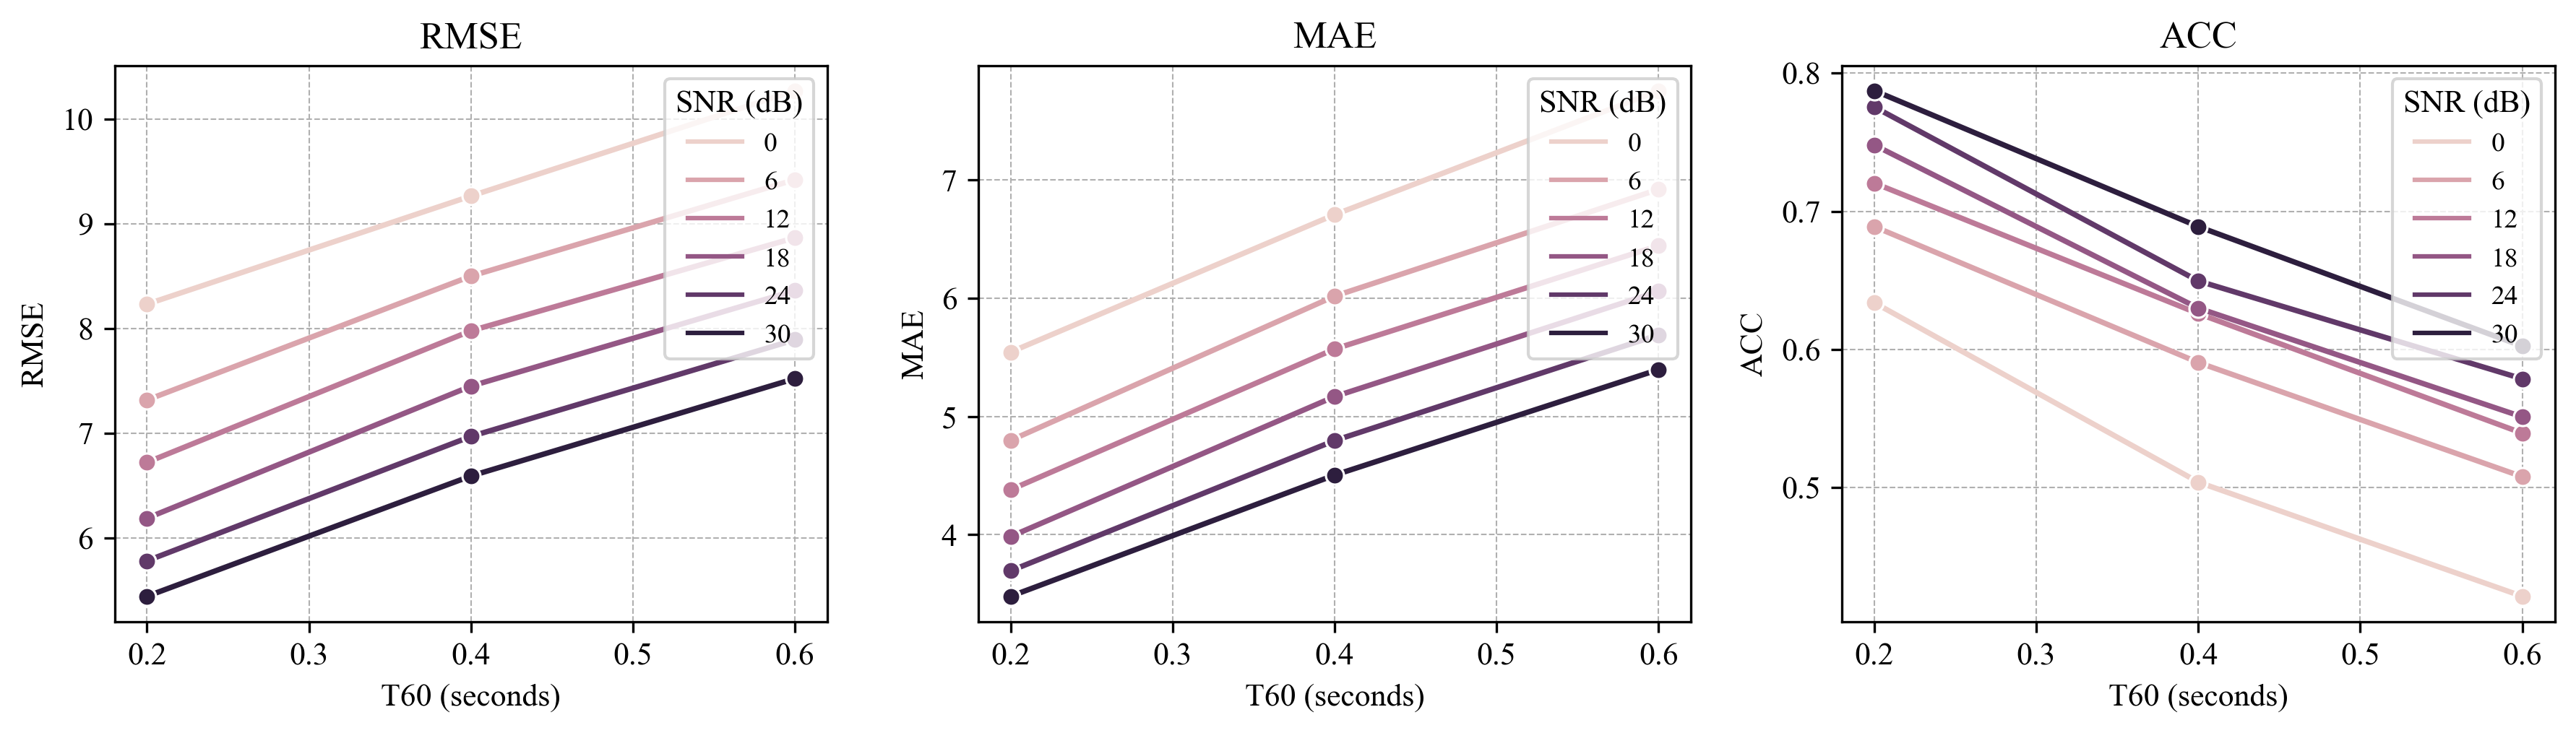

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import re

file = "D:/multi_source_localization/dereverb/dereverberation/experiments/prob_pgcc/eval.txt"

data = []
with open(file, "r") as f:
    for line in f:
        match = re.findall(r"SNR:\s*(\d+), T60:\s*([\d.]+), loss:\s*([\d.]+), RMSE:\s*([\d.]+), GCC RMSE:.*?, MAE:\s*([\d.]+), GCC MAE:.*?, ACC:\s*([\d.]+), GCC ACC:.*?", line)
        if match:
            snr, t60, loss, rmse, mae, acc = match[0]
            data.append({
                "SNR": int(snr),
                "T60": float(t60),
                "Loss": float(loss),
                "RMSE": float(rmse),
                "MAE": float(mae),
                "ACC": float(acc)
            })

df = pd.DataFrame(data)

import seaborn as sns
import matplotlib.pyplot as plt

# 논문 스타일 적용
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5

# 그래프 목록
metrics = [ "RMSE", "MAE", "ACC"]

# subplot 구성: 한 줄에 최대 3개씩
cols = 3
rows = 1

fig, axs = plt.subplots(rows, cols, figsize=(cols*4,rows*3.5), dpi=300,constrained_layout=True)
axs = axs.flatten()  # 1D 배열로 평탄화

for i, metric in enumerate(metrics):
    ax = axs[i]
    sns.lineplot(
        data=df, x="T60", y=metric, hue="SNR", marker="o", linewidth=1.8, ax=ax
    )
    ax.set_title(metric)
    ax.set_xlabel("T60 (seconds)", fontsize=10.5)
    ax.set_ylabel(metric,fontsize=10.5)
    ax.tick_params(axis='both', which='major', labelsize=10.5)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(title="SNR (dB)", fontsize=9, title_fontsize=10.5, loc="upper right")
    ax.grid(True, linestyle='--', linewidth=0.5)

# 빈 subplot 제거
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

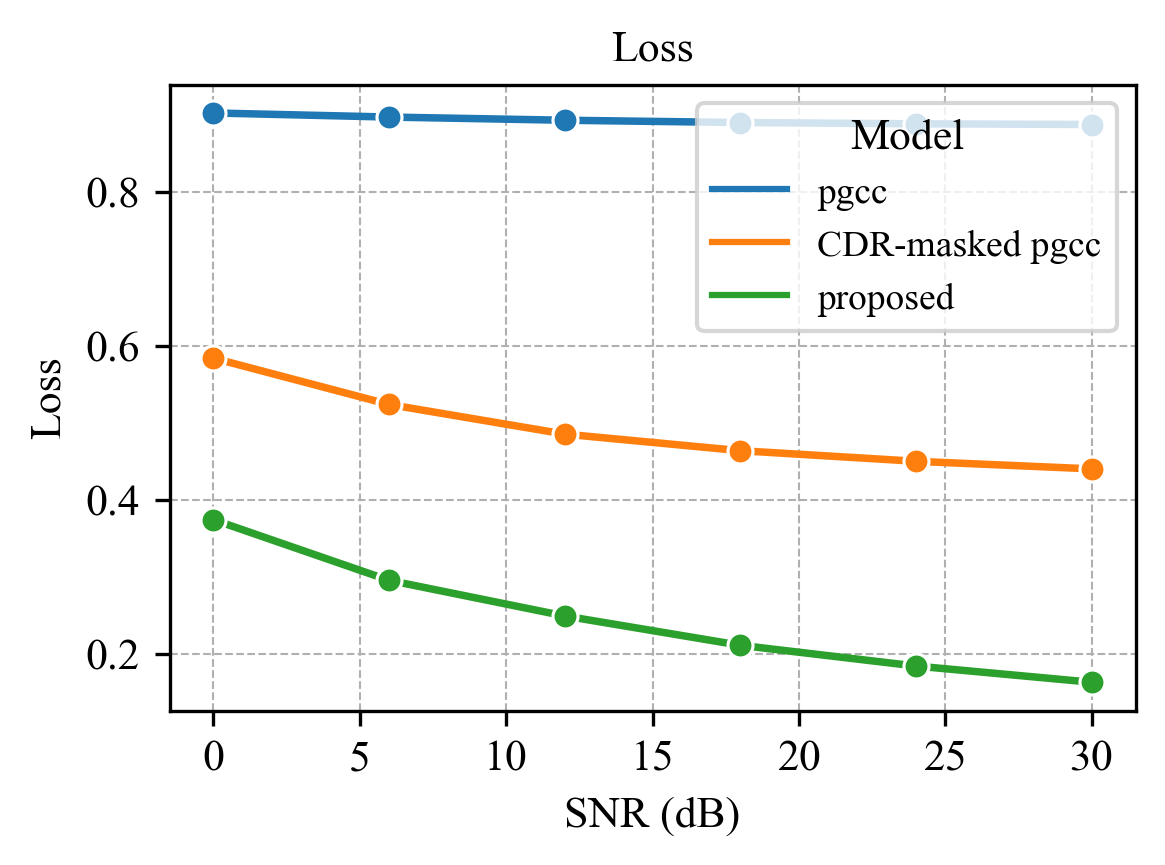

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

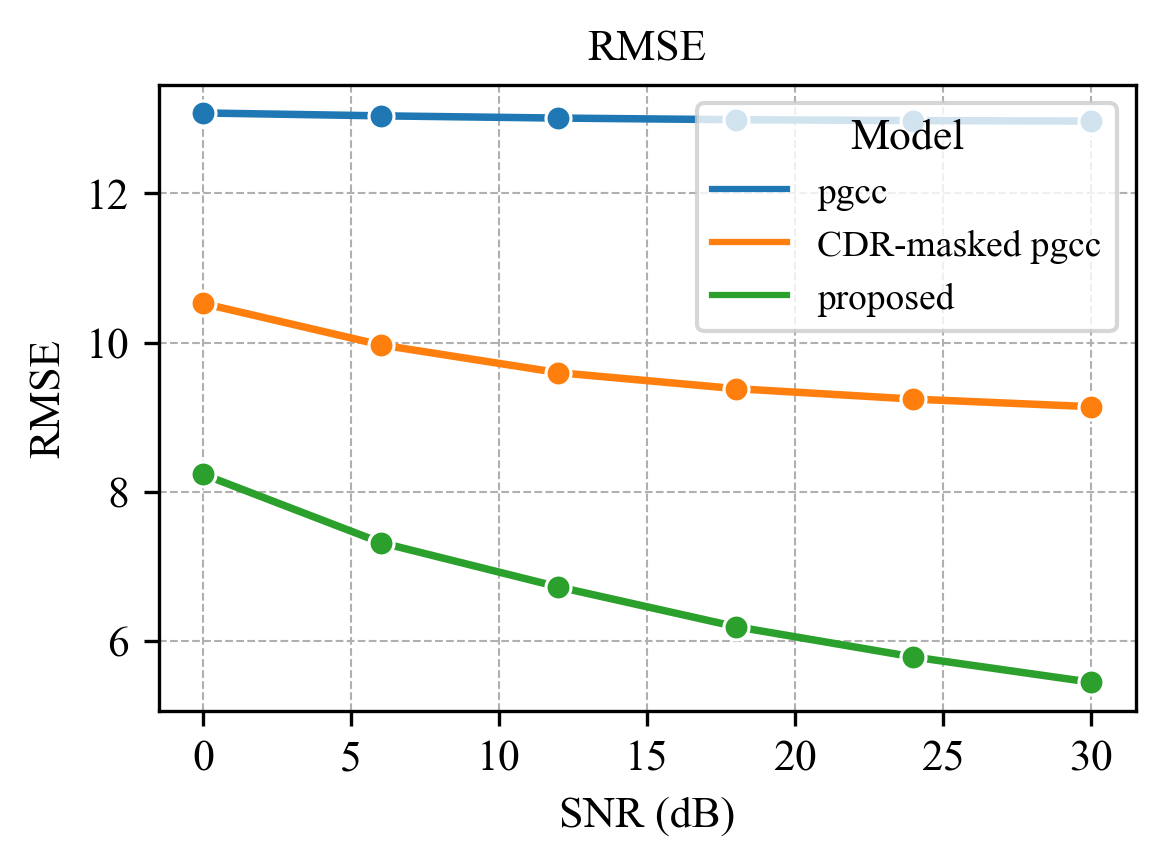

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

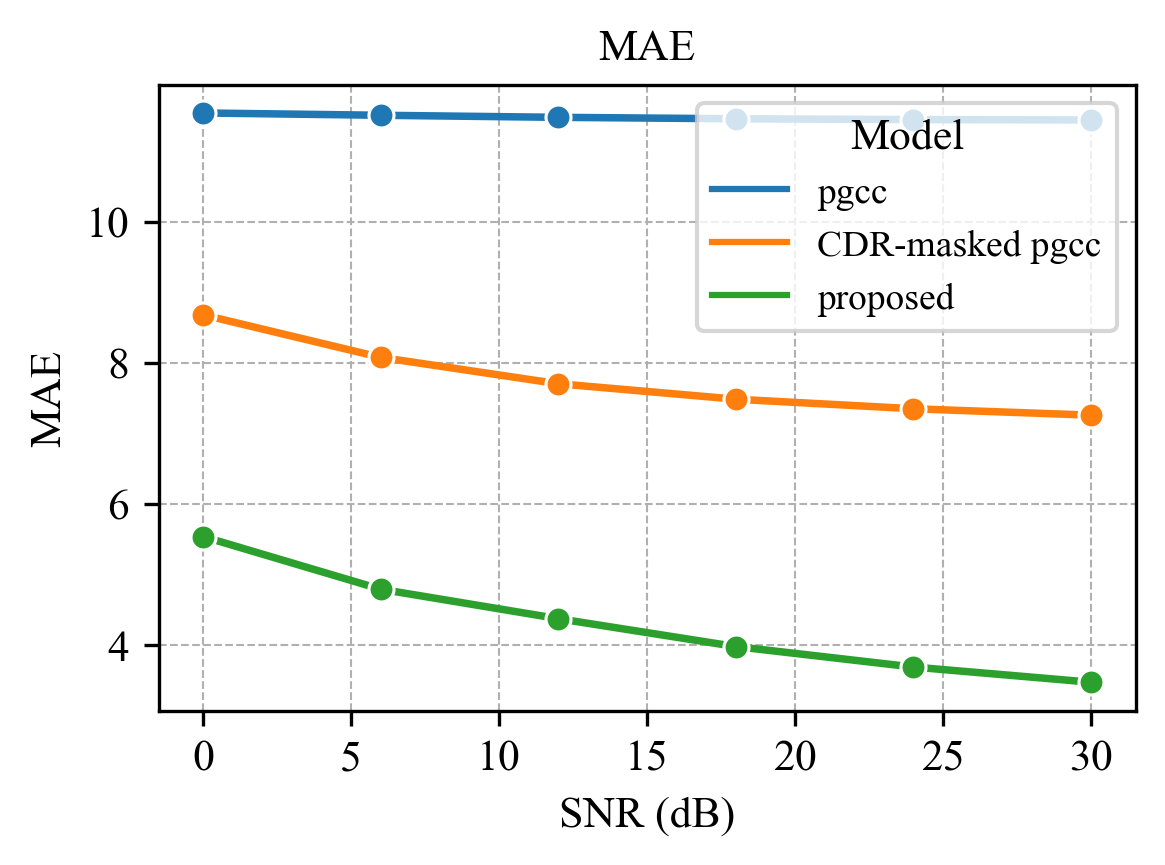

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

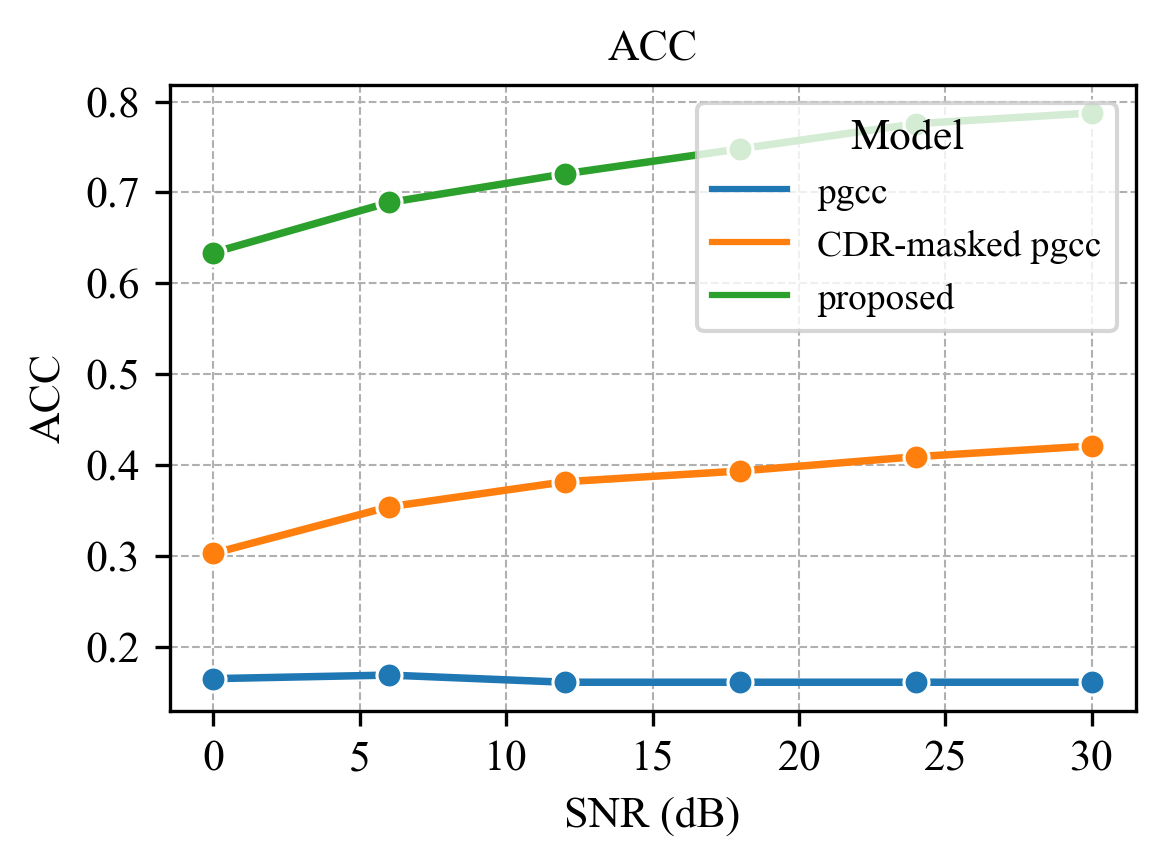

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 비교 대상 파일 리스트와 레이블
files = [
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/tdoa_exp/eval.txt","pgcc"),
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/mpgcc/eval.txt","CDR-masked pgcc"),
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/prob_pgcc/eval.txt", "proposed"),
]

# 모든 데이터를 담을 리스트
all_data = []

# 각 파일별 데이터 읽기 및 파싱
for filename, label in files:
    with open(filename, "r") as f:
        for line in f:
            match = re.findall(
                r"SNR:\s*(\d+), T60:\s*([\d.]+), loss:\s*([\d.]+), RMSE:\s*([\d.]+), GCC RMSE:.*?, MAE:\s*([\d.]+), GCC MAE:.*?, ACC:\s*([\d.]+), GCC ACC:.*?",
                line
            )
            if match:
                snr, t60, loss, rmse, mae, acc = match[0]
                all_data.append({
                    "Model": label,
                    "SNR": int(snr),
                    "T60": float(t60),
                    "Loss": float(loss),
                    "RMSE": float(rmse),
                    "MAE": float(mae),
                    "ACC": float(acc)
                })

# 데이터프레임으로 변환
df_all = pd.DataFrame(all_data)

# T60 = 0.2일 때만 필터링
df_filtered = df_all[df_all["T60"] == 0.2]

import seaborn as sns
import matplotlib.pyplot as plt

# 논문 스타일 설정
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5

# 시각화: SNR에 따른 성능 변화 (T60 = 0.2 조건)
metrics = ["Loss","RMSE", "MAE", "ACC"]  # 'Loss' 제외
for metric in metrics:
    plt.figure(figsize=(4,3), dpi=300)
    sns.lineplot(
        data=df_filtered, x="SNR", y=metric, hue="Model",
        marker="o", linewidth=1.8
    )
    plt.title(f"{metric}", fontsize=10.5)
    plt.xlabel("SNR (dB)", fontsize=10.5)
    plt.ylabel(metric, fontsize=10.5)
    plt.tick_params(axis='both', which='major', labelsize=10.5)
    plt.legend(title="Model", fontsize=9, title_fontsize=10.5, loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

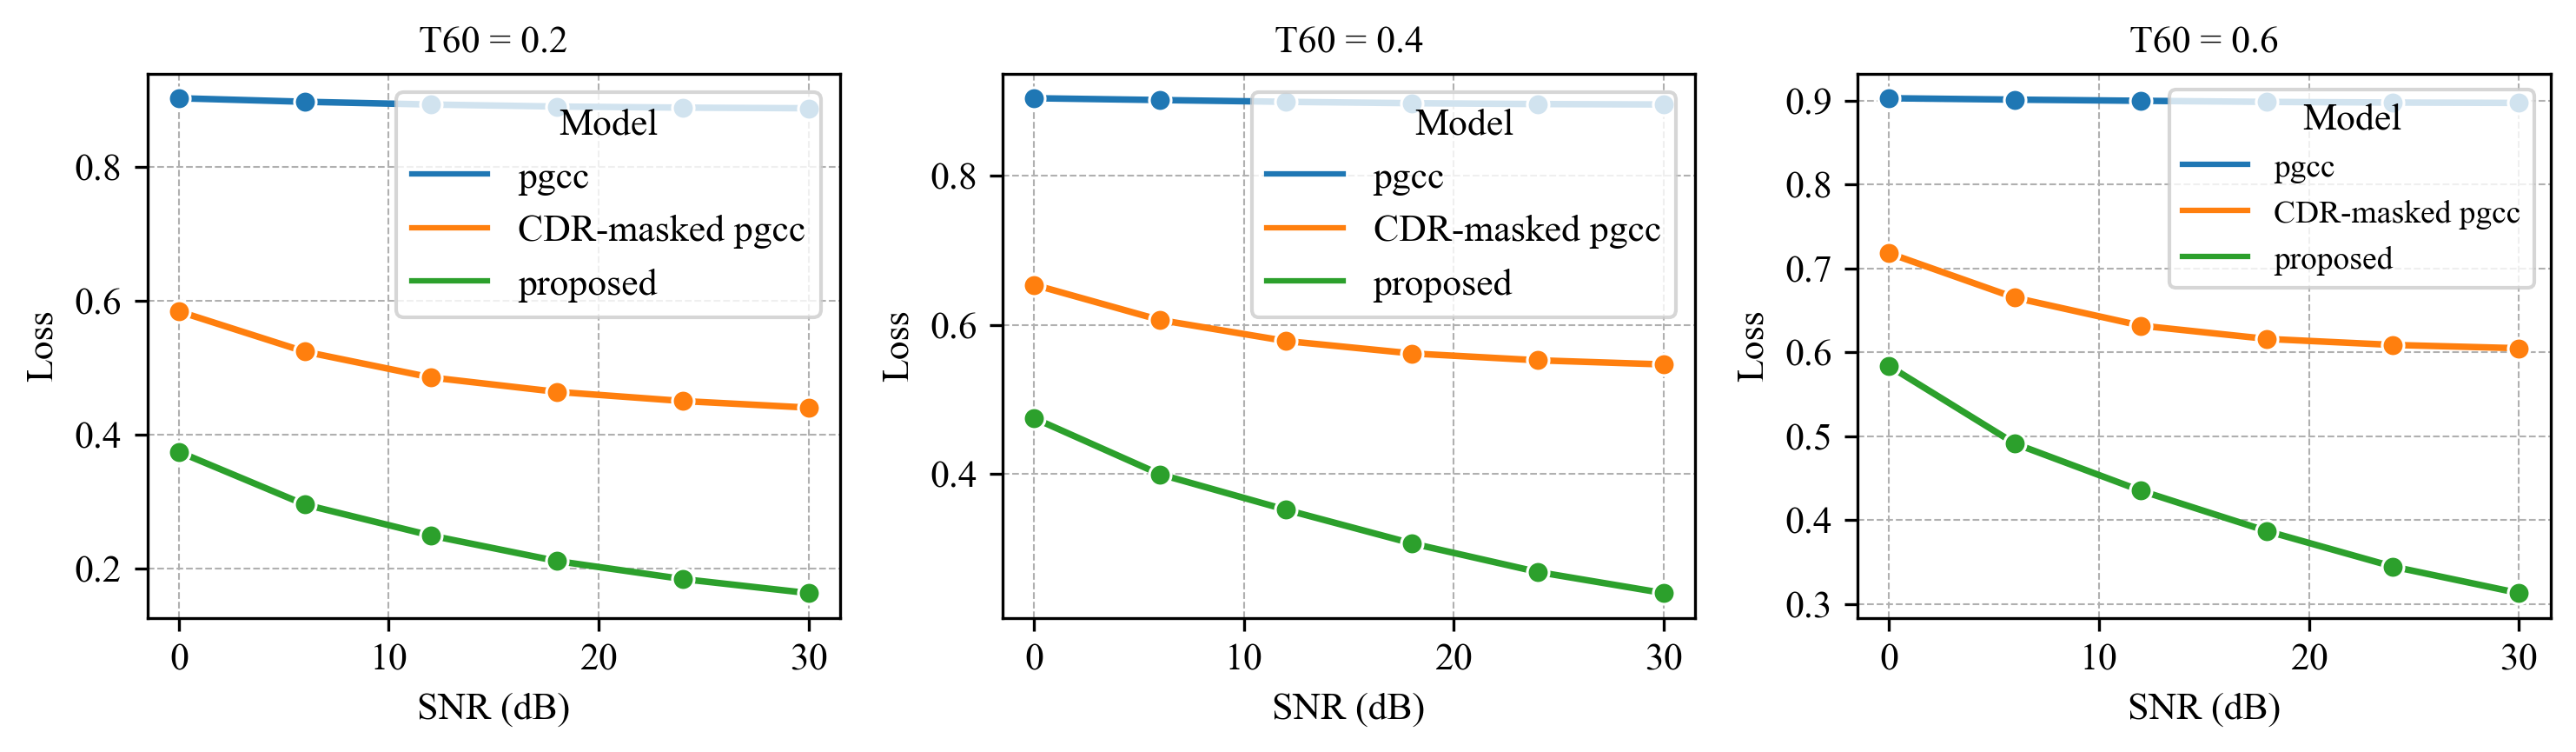

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 재설정된 환경에서 데이터를 재정의
files = [
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/tdoa_exp/eval.txt","pgcc"),
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/mpgcc/eval.txt","CDR-masked pgcc"),
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/prob_pgcc/eval.txt", "proposed"),
]

# 모든 데이터를 담을 리스트
all_data = []

# 각 파일별 데이터 읽기 및 파싱
for filename, label in files:
    try:
        with open(filename, "r") as f:
            for line in f:
                match = re.findall(
                    r"SNR:\s*(\d+), T60:\s*([\d.]+), loss:\s*([\d.]+), RMSE:\s*([\d.]+), GCC RMSE:.*?, MAE:\s*([\d.]+), GCC MAE:.*?, ACC:\s*([\d.]+), GCC ACC:.*?",
                    line
                )
                if match:
                    snr, t60, loss, rmse, mae, acc = match[0]
                    all_data.append({
                        "Model": label,
                        "SNR": int(snr),
                        "T60": float(t60),
                        "Loss": float(loss),
                    })
    except FileNotFoundError:
        continue

# 데이터프레임으로 변환
df_all = pd.DataFrame(all_data)

# 논문 스타일 설정
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5

# 필요한 T60 값
t60_values = [0.2, 0.4, 0.6]

# 1 row 에 3개 그래프
fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=300)

for i, t60 in enumerate(t60_values):
    df_filtered = df_all[df_all["T60"] == t60]
    sns.lineplot(
        data=df_filtered,
        x="SNR",
        y="Loss",
        hue="Model",
        marker="o",
        linewidth=1.8,
        ax=axs[i]
    )
    axs[i].set_title(f"T60 = {t60}", fontsize=10.5)
    axs[i].set_xlabel("SNR (dB)", fontsize=10.5)
    axs[i].set_ylabel("Loss", fontsize=10.5)
    axs[i].tick_params(axis='both', which='major', labelsize=10.5)
    axs[i].grid(True, linestyle='--', linewidth=0.5)

axs[2].legend(title="Model", fontsize=9, title_fontsize=10.5, loc='upper right')
plt.tight_layout()
plt.show()


c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

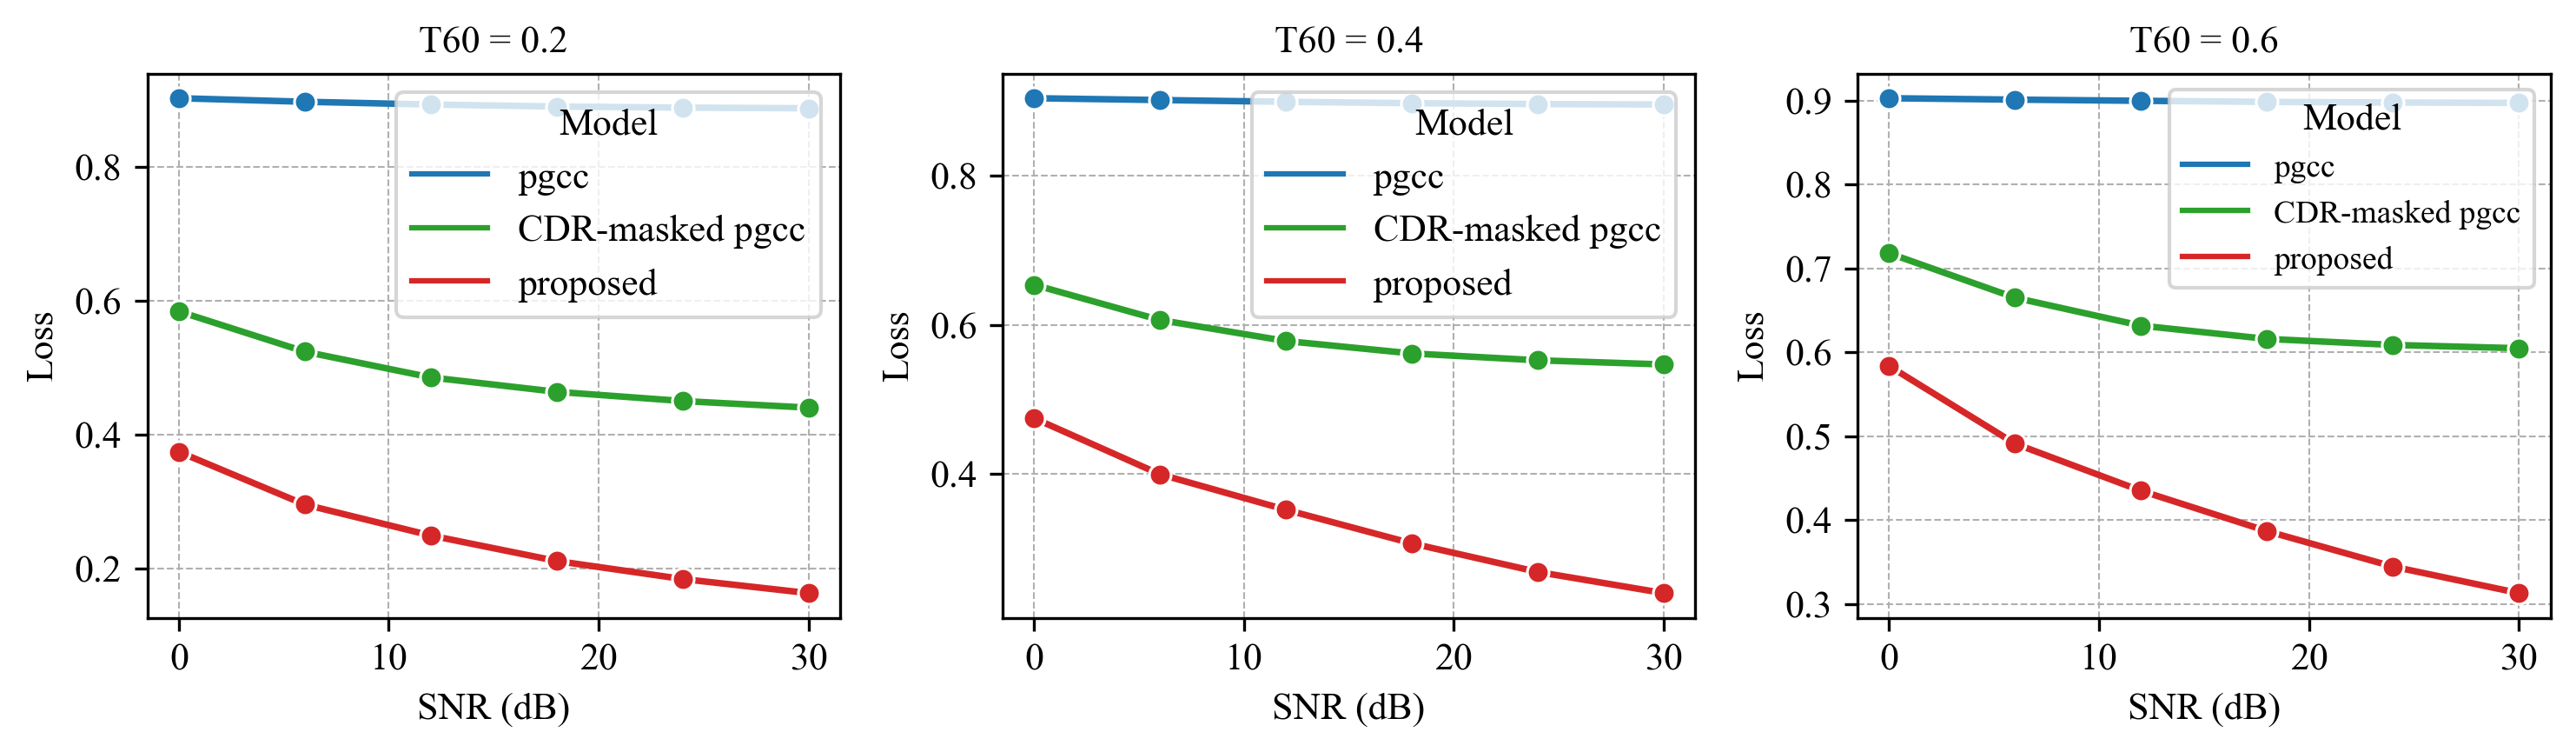

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 재설정된 환경에서 데이터를 재정의
files = [
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/tdoa_exp/eval.txt","pgcc"),
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/mpgcc/eval.txt","CDR-masked pgcc"),
    ("D:/multi_source_localization/dereverb/dereverberation/experiments/prob_pgcc/eval.txt", "proposed"),
]

# 모든 데이터를 담을 리스트
all_data = []

# 각 파일별 데이터 읽기 및 파싱
for filename, label in files:
    try:
        with open(filename, "r") as f:
            for line in f:
                match = re.findall(
                    r"SNR:\s*(\d+), T60:\s*([\d.]+), loss:\s*([\d.]+), RMSE:\s*([\d.]+), GCC RMSE:.*?, MAE:\s*([\d.]+), GCC MAE:.*?, ACC:\s*([\d.]+), GCC ACC:.*?",
                    line
                )
                if match:
                    snr, t60, loss, rmse, mae, acc = match[0]
                    all_data.append({
                        "Model": label,
                        "SNR": int(snr),
                        "T60": float(t60),
                        "Loss": float(loss),
                    })
    except FileNotFoundError:
        continue

# 데이터프레임으로 변환
df_all = pd.DataFrame(all_data)

# 논문 스타일 설정
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5

import seaborn as sns
import matplotlib.pyplot as plt

# RGB 색상 팔레트 수동 정의 (모델 수에 맞게 조절)
rgb_palette = {
    "pgcc": (0.0, 0.4, 1.0),         # 파란색 (Blue)
    "CDR-masked pgcc": (0.0, 0.7, 0.0),  # 초록색 (Green)
    "proposed": (1.0, 0.2, 0.2),     # 빨간색 (Red)
}

import seaborn as sns
import matplotlib.pyplot as plt

# 논문 스타일 설정
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5

# RGB 계열 팔레트 지정 (모델 수에 맞춤)
rgb_palette = ["#1f77b4", "#2ca02c", "#d62728"]  # Blue, Green, Red

# 1 row에 3개 그래프
fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=300)

for i, t60 in enumerate(t60_values):
    df_filtered = df_all[df_all["T60"] == t60]
    
    sns.lineplot(
        data=df_filtered,
        x="SNR",
        y="Loss",
        hue="Model",
        marker="o",
        linewidth=1.8,
        palette=rgb_palette,
        ax=axs[i]
    )
    
    axs[i].set_title(f"T60 = {t60}", fontsize=10.5)
    axs[i].set_xlabel("SNR (dB)", fontsize=10.5)
    axs[i].set_ylabel("Loss", fontsize=10.5)
    axs[i].tick_params(axis='both', which='major', labelsize=10.5)
    axs[i].grid(True, linestyle='--', linewidth=0.5)

# 범례는 마지막 그래프에만
axs[2].legend(title="Model", fontsize=9, title_fontsize=10.5, loc='upper right')

plt.tight_layout()
plt.show()
